In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg as LA
from scipy.sparse import csr_matrix
from sklearn import decomposition, metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
                              GradientBoostingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             classification_report, confusion_matrix, log_loss,
                             make_scorer, plot_precision_recall_curve,
                             plot_roc_curve, precision_recall_curve,
                             roc_auc_score, roc_curve, plot_confusion_matrix)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
%matplotlib inline

In [29]:
def grid_search_cv_and_test(model, grid_search_params, X_train, y_train, X_test, y_test):

    gs = GridSearchCV(model, grid_search_params, verbose = 1, cv = 4, n_jobs = -1)
    gs_results = gs.fit(X_train, y_train)
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    roc = plot_roc_curve(gs_results_rf.best_estimator_, X_test, y_test)
    precision_recall = plot_precision_recall_curve(gs_results_rf.best_estimator_, X_test, y_test)
    plt.show()
    model_performance_evaluation(y_test, gs_results.best_estimator_.predict(X_test))
    
    return gs_results.best_estimator_

In [3]:
def model_performance_evaluation(y_test, y_pred):
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print('\n')

In [4]:
relations_df = pd.read_csv("../data/relations_features.csv", delimiter="\t", index_col="src")

relations_df.head()

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,dt_1,dt_2,dt_3,dt_4,dt_5,dt_6,dt_7,dout_1,dout_2,dout_3,...,duni_6,duni_7,dnbi_1,dnbi_2,dnbi_3,dnbi_4,dnbi_5,dnbi_6,dnbi_7,n_bidir
src,,,,,,,,,,,,,,,,,,,,,
1,0,0,40,61,53,121,0,0,0,22,...,115,0,0,0,5,5,16,0,0,24
2,1,0,28,41,65,159,0,0,0,0,...,133,0,0,0,0,3,1,0,0,12
3,0,9,29,8,6,5,0,0,4,24,...,5,0,0,1,2,1,0,0,0,3
4,0,0,5,9,15,7,0,0,0,1,...,7,0,0,0,1,3,4,0,0,5
5,0,0,5,11,11,11,0,0,0,4,...,10,0,0,0,0,3,2,0,0,7


In [219]:
relations_df.isna().any()

dt_1       False
dt_2       False
dt_3       False
dt_4       False
dt_5       False
dt_6       False
dt_7       False
dout_1     False
dout_2     False
dout_3     False
dout_4     False
dout_5     False
dout_6     False
dout_7     False
duni_1     False
duni_2     False
duni_3     False
duni_4     False
duni_5     False
duni_6     False
duni_7     False
dnbi_1     False
dnbi_2     False
dnbi_3     False
dnbi_4     False
dnbi_5     False
dnbi_6     False
dnbi_7     False
n_bidir    False
dtype: bool

In [5]:
user_data_pagerank_df = pd.read_csv("../data/usersdata_with_pr.csv", delimiter=",", index_col="userId").drop("Unnamed: 0", axis=1)
user_data_pagerank_df.head()

,sex,timePassedValidation,ageGroup,label,pagerank_1,pagerank_2,pagerank_3,pagerank_4,pagerank_5,pagerank_6,pagerank_7
userId,,,,,,,,,,,
1,M,0.9000,30,0,0.000000,0.000000e+00,5.218214e-07,3.841856e-07,7.475450e-07,7.674321e-07,0.0
2,F,1.0000,20,0,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.368759e-07,0.0
3,M,0.1375,30,0,0.000000,4.663933e-07,4.241208e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,M,0.3875,20,0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.047452e-07,0.0
5,M,0.0125,20,0,0.000000,0.000000e+00,3.326827e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0


##  Merging the data

In [6]:
df = user_data_pagerank_df.merge(relations_df, 
                           how='inner', left_index=True, right_index=True)

df = pd.concat([df, pd.get_dummies(df['sex'], prefix='sex', drop_first=True)], axis=1).drop(['sex'], axis=1)

In [9]:
len(df)

5321960

## Sampling

In [12]:
# Assign weights to sample equal number of Spam and Ham
df["inv_value_count"] = 0
df["inv_value_count"][df.label == 1] = 1/df["label"].value_counts()[1]
df["inv_value_count"][df.label == 0] = 1/df["label"].value_counts()[0]

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
# to sample equal number of spam/ham we add weight with inv_value_count columns
df_sample = df.sample(n = 100000, weights = 'inv_value_count').drop(["inv_value_count"], axis=1)

In [16]:
df_sample.head()

,timePassedValidation,ageGroup,label,pagerank_1,pagerank_2,pagerank_3,pagerank_4,pagerank_5,pagerank_6,pagerank_7,...,duni_7,dnbi_1,dnbi_2,dnbi_3,dnbi_4,dnbi_5,dnbi_6,dnbi_7,n_bidir,sex_M
5352839,0.0000,20,1,0.000000,0.0,3.326827e-07,0.000000,0.000000e+00,0.0,0.00000,...,0,0,0,0,0,0,0,0,0,0
2901130,1.0000,20,0,0.000000,0.0,0.000000e+00,0.000000,7.162526e-07,0.0,0.00000,...,0,0,0,0,1,1,1,0,31,0
2796581,0.8875,30,0,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.00000,...,0,0,0,13,26,1,0,0,70,1
1385195,0.0000,20,1,0.000001,0.0,0.000000e+00,0.000012,7.073937e-07,0.0,0.00001,...,3,0,0,0,123,0,0,0,209,0
4054594,0.0625,50,0,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.00000,...,0,0,0,0,0,0,0,0,0,1


In [18]:
graph_features_subset = df_sample.drop(['sex_M', 'timePassedValidation', 'ageGroup'], axis=1)

In [19]:
graph_features_subset.head()

,label,pagerank_1,pagerank_2,pagerank_3,pagerank_4,pagerank_5,pagerank_6,pagerank_7,dt_1,dt_2,...,duni_6,duni_7,dnbi_1,dnbi_2,dnbi_3,dnbi_4,dnbi_5,dnbi_6,dnbi_7,n_bidir
5352839,1,0.000000,0.0,3.326827e-07,0.000000,0.000000e+00,0.0,0.00000,0,0,...,0,0,0,0,0,0,0,0,0,0
2901130,0,0.000000,0.0,0.000000e+00,0.000000,7.162526e-07,0.0,0.00000,0,0,...,295,0,0,0,0,1,1,1,0,31
2796581,0,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.00000,13,0,...,89,0,0,0,13,26,1,0,0,70
1385195,1,0.000001,0.0,0.000000e+00,0.000012,7.073937e-07,0.0,0.00001,6,0,...,56,3,0,0,0,123,0,0,0,209
4054594,0,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.00000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
X, y = graph_features_subset.drop("label", axis=1), graph_features_subset[["label"]]
X, y = X.values, y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   20.3s finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/model_selection/_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.737225
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': 15, 'n_estimators': 40}


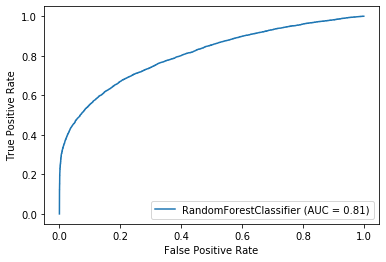

In [22]:
grid_params_rf = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15],
    'n_estimators': [10, 20, 40]
}
gs_rf = GridSearchCV(RandomForestClassifier(), grid_params_rf, verbose = 1, cv = 4, n_jobs = -1)
gs_results_rf = gs_rf.fit(X_train, y_train)
print(gs_results_rf.best_score_)
print(gs_results_rf.best_estimator_)
print(gs_results_rf.best_params_)

from sklearn.metrics import plot_roc_curve
rf_disp = plot_roc_curve(gs_results_rf.best_estimator_, X_test, y_test)
plt.show()

In [185]:
rf_best_params_ = {'bootstrap': True, 'max_depth': 5, 'n_estimators': 20}
rf = RandomForestClassifier(**rf_best_params_)
rf.fit(X_train,y_train)
rf_predict = rf.predict(X_test)
model_performance_evaluation(y_test, rf_predict)

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


=== Confusion Matrix ===
[[9028 1359]
 [4738 4875]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.66      0.87      0.75     10387
           1       0.78      0.51      0.62      9613

    accuracy                           0.70     20000
   macro avg       0.72      0.69      0.68     20000
weighted avg       0.72      0.70      0.68     20000





In [186]:
rf.score(X_train, y_train)

0.70425

## XGBoost

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 25.4min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7407750000000001
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)
{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}


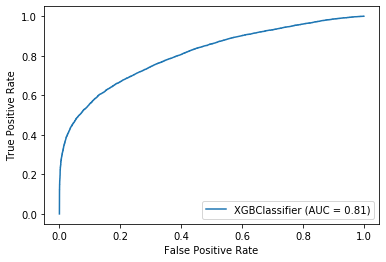

In [187]:
xgb = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

grid_params_xgb = {
    'max_depth': [5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01, 0.05]
}

gs_xgb = GridSearchCV(xgb, grid_params_xgb, verbose = 1, cv = 4, n_jobs = -1)
gs_results_xgb = gs_xgb.fit(X_train, y_train)

print(gs_results_xgb.best_score_)
print(gs_results_xgb.best_estimator_)
print(gs_results_xgb.best_params_)

xgb_disp = plot_roc_curve(gs_results_xgb.best_estimator_, X_test, y_test)
plt.show()

# Adding user data

In [23]:
X, y = df_sample.drop("label", axis=1), df_sample[["label"]]
X, y = X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.5min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/model_selection/_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7736000000000001
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': 17, 'n_estimators': 200}


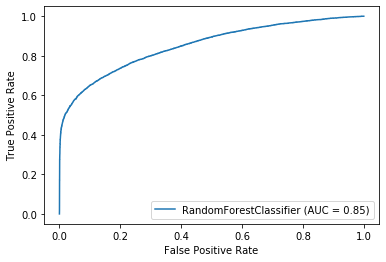

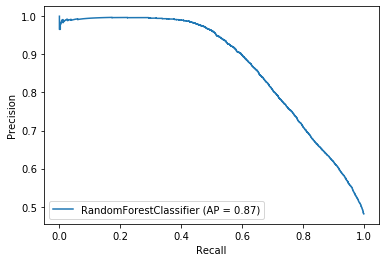

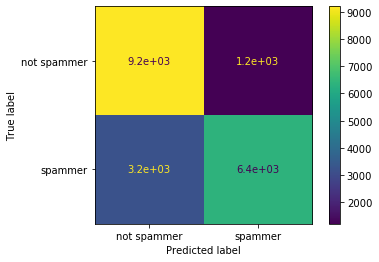

=== Confusion Matrix ===
[[9206 1206]
 [3214 6374]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.88      0.81     10412
           1       0.84      0.66      0.74      9588

    accuracy                           0.78     20000
   macro avg       0.79      0.77      0.77     20000
weighted avg       0.79      0.78      0.78     20000





In [24]:
grid_params_rf = {
    'bootstrap': [True],
    'max_depth': [15, 17, 20],
    'n_estimators': [100, 120, 150, 200]
}
gs_rf = GridSearchCV(RandomForestClassifier(), grid_params_rf, verbose = 1, cv = 4, n_jobs = -1)
gs_results_rf = gs_rf.fit(X_train, y_train)
print(gs_results_rf.best_score_)
print(gs_results_rf.best_estimator_)
print(gs_results_rf.best_params_)
from sklearn.metrics import plot_roc_curve
rf_roc = plot_roc_curve(gs_results_rf.best_estimator_, X_test, y_test)
rf_precision_recall = plot_precision_recall_curve(gs_results_rf.best_estimator_, X_test, y_test)
rf_confusion_matrix = plot_confusion_matrix(gs_results_rf.best_estimator_, X_test, y_test,
                                           display_labels=["not spammer", "spammer"])
plt.show()
model_performance_evaluation(y_test, gs_results_rf.best_estimator_.predict(X_test))

## XGBoost

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  2.1min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7722125000000001
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 120}


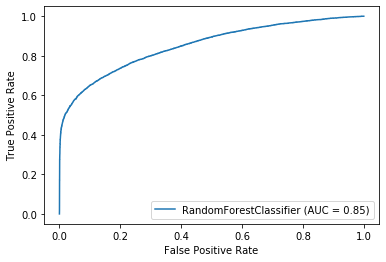

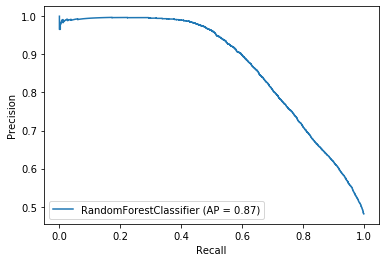

=== Confusion Matrix ===
[[9189 1223]
 [3243 6345]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     10412
           1       0.84      0.66      0.74      9588

    accuracy                           0.78     20000
   macro avg       0.79      0.77      0.77     20000
weighted avg       0.79      0.78      0.77     20000





XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [30]:
xgb = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

grid_params_xgb = {
    'max_depth': [5, 7],
    'n_estimators': [100, 120],
    'learning_rate': [0.1, 0.05]
}

grid_search_cv_and_test(model=xgb, grid_search_params=grid_params_xgb, X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test)

## Gradient Boosting Classifier

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 19.0min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7741499999999999
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=9,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
{'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200}


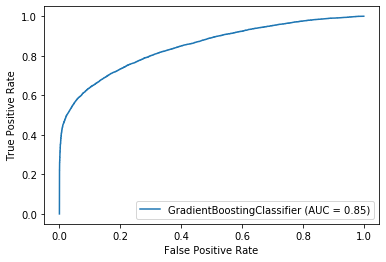

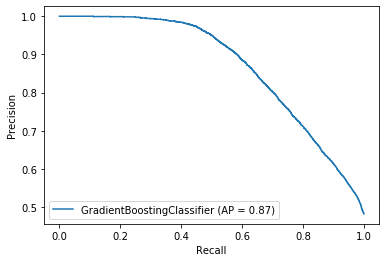

In [191]:
grid_params_gb = {
    'max_depth': [7, 9, 11],
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.01]
}
grid_search_cv_and_test(model=GRadientBoostingClassifier(), grid_search_params=grid_params_gb, X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test)

## Logistic Classification

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.8s finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:937: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.707625
RidgeClassifier(alpha=0.5, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
{'alpha': 0.5}


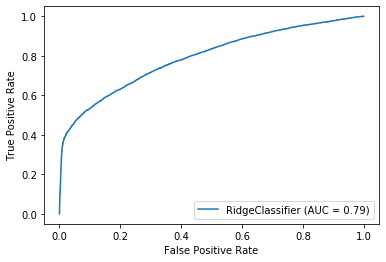

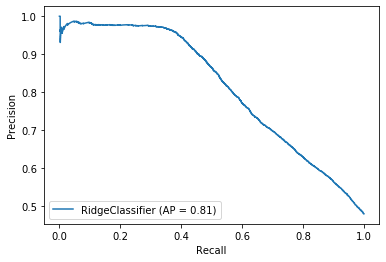

In [192]:
grid_params_rc = {
    "alpha": [1.0, 0.1, 0.05, 0.5]
}
gs_rc = GridSearchCV(RidgeClassifier(), grid_params_rc, verbose = 1, cv = 4, n_jobs = -1)
gs_results_rc = gs_rc.fit(X_train, y_train)
print(gs_results_rc.best_score_)
print(gs_results_rc.best_estimator_)
print(gs_results_rc.best_params_)
rc_roc = plot_roc_curve(gs_results_rc.best_estimator_, X_test, y_test)
rc_precision_recall = plot_precision_recall_curve(gs_results_rc.best_estimator_, X_test, y_test)
plt.show()

## Stacking

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


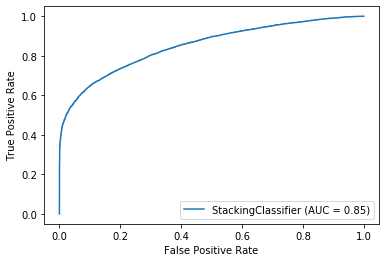

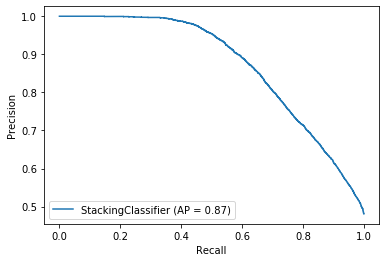

In [193]:
estimators = [('rf', gs_results_rf.best_estimator_),
             ('xgb', gs_results_xgb.best_estimator_),
             ('gb', gs_results_gb.best_estimator_),
             ('rc', gs_results_rc.best_estimator_),]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(X_train, y_train)
rf_roc = plot_roc_curve(clf, X_test, y_test)
rf_precision_recall = plot_precision_recall_curve(clf, X_test, y_test)
plt.show()